In [103]:
# genral imports
import os
import numpy as np
import matplotlib.pyplot as plt  
from scipy.stats import multivariate_normal,norm,gaussian_kde
import scipy.stats as st


# GUI related imports
import pdb
import tkinter as tk
from PIL import Image,ImageTk

# tf imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# GPU check
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# function for sampling layer
class sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
latent_dim = 2

# function for encoder model
def build_encoder():
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

In [5]:
# function for decoder model
def build_decoder():
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

In [6]:
# VAE class
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [8]:
# importing data
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

# creating encoder and decoder instances
encoder=build_encoder()
decoder=build_decoder()

# creating VAE instances
vae = VAE(encoder, decoder)

# compling and training vae model
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=300, batch_size=128)

Epoch 1/300
547/547 [==============================] - 23s 41ms/step - loss: 212.8260 - reconstruction_loss: 210.1444 - kl_loss: 2.6816
Epoch 2/300
547/547 [==============================] - 20s 37ms/step - loss: 185.7462 - reconstruction_loss: 183.3991 - kl_loss: 2.3470
Epoch 3/300
547/547 [==============================] - 21s 39ms/step - loss: 178.4168 - reconstruction_loss: 175.6662 - kl_loss: 2.7506
Epoch 4/300
547/547 [==============================] - 20s 37ms/step - loss: 162.4391 - reconstruction_loss: 158.6734 - kl_loss: 3.7657
Epoch 5/300
547/547 [==============================] - 21s 38ms/step - loss: 157.3996 - reconstruction_loss: 153.5933 - kl_loss: 3.8063
Epoch 6/300
547/547 [==============================] - 21s 38ms/step - loss: 154.9283 - reconstruction_loss: 151.1165 - kl_loss: 3.8118
Epoch 7/300
547/547 [==============================] - 22s 40ms/step - loss: 153.5193 - reconstruction_loss: 149.7021 - kl_loss: 3.8172
Epoch 8/300
547/547 [===========================

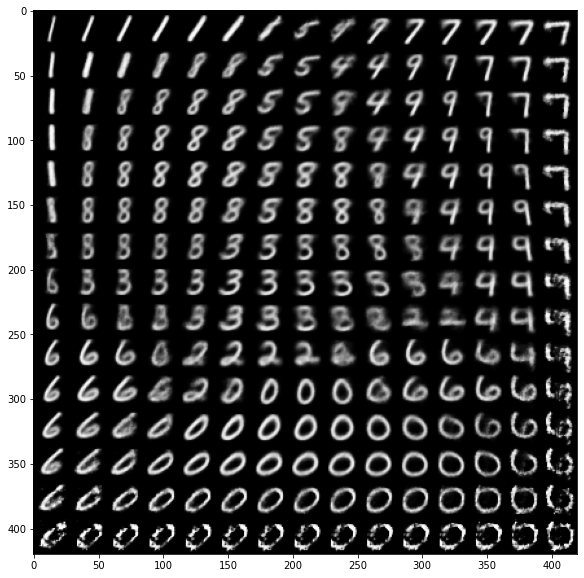

In [9]:
# displaying a 2D manifold of the digits

# figure with 15x15 digits
n = 15 
digit_size = 28

'''linearly spaced coordinates on the unit square were transformed through the 
inverse CDF (ppf)  of the Gaussian to produce values of the latent variables z
'''

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))

z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.show()

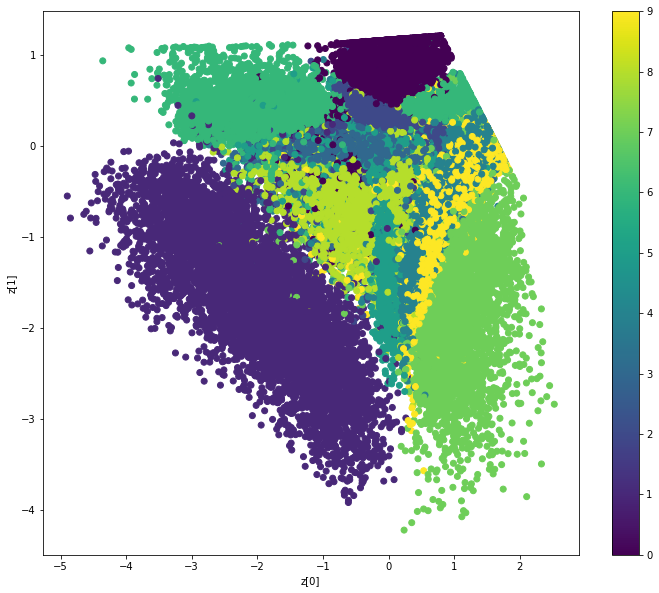

In [16]:
# display a 2D plot of the digit classes in the latent space
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, decoder, x_train, y_train)

Text(0.5, 0.92, 'Gaussian 2D KDE')

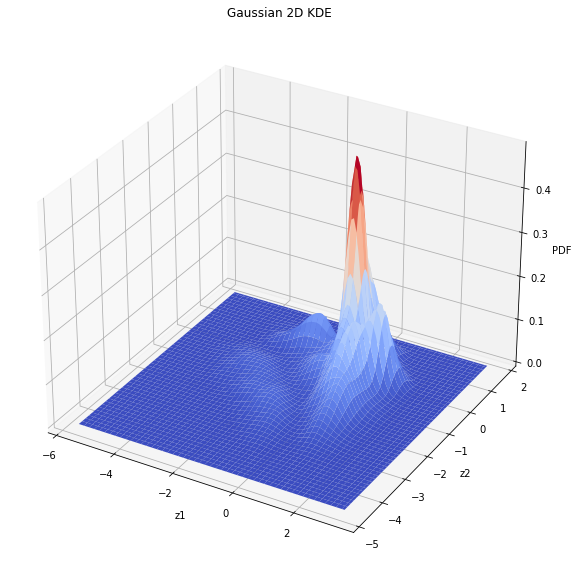

In [100]:
# Estmating prob. dist. gaussian KDE 
x = z_mean[:, 0]
y = z_mean[:, 1]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f,  cmap='coolwarm', edgecolor='none')
ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_zlabel('PDF')
ax.set_title('Gaussian 2D KDE')

In [117]:
# Building GUI

# createing root window
root = tk.Tk()
root.title('MNIST')
zoom = 4

preds = encoder.predict(mnist_digits)

std = np.std(preds[0], axis=0)
std_inds = std.argsort()

# convert predictions to data format suitable for gui
def clip(arr):
    return (arr / np.max(arr) * 255).astype('uint8')
    
global starting_vec 
starting_vec = preds[0][0:1,:]
latent = starting_vec
pred = decoder.predict(latent)

# converting numpy array to image in gui and place it inside the window
mat_shape=[28,28]
img = Image.fromarray(clip(pred.reshape(mat_shape).astype(float)))
img =  ImageTk.PhotoImage(image=img, master = root)
img = img._PhotoImage__photo.zoom(zoom)
panel = tk.Label(root, image=img)
panel.pack(side=tk.LEFT, fill=tk.Y)

# constant to adjust scaling of latent variable
power = 0.1

# add scrollbars
def create_img1(var):
    global sclb1_prev
    value = scrollbar1.get()
    # change value of latent vector displayed in a single latent variable
    if value > sclb1_prev:
        starting_vec[0,std_inds[0]] += (value - sclb1_prev) * std[std_inds[0]] * power
        sclb1_prev = value
    else:
        starting_vec[0,std_inds[0]] -= (sclb1_prev - value) * std[std_inds[0]] * power
        sclb1_prev = value
    # command to convert numpy array to image in gui and place it inside the window    
    img = Image.fromarray(clip(decoder.predict(starting_vec).reshape(mat_shape).astype(float)))
    img =  ImageTk.PhotoImage(image=img, master = root)
    img = img._PhotoImage__photo.zoom(zoom)
    panel.config(image = img)
    panel.image = img

def create_img2(var):
    value = scrollbar2.get()
    global sclb2_prev
    if value > sclb2_prev:
        starting_vec[0,std_inds[1]] += (value - sclb2_prev) * std[std_inds[1]] * power
        sclb2_prev = value
    else:
        starting_vec[0,std_inds[1]] -= (sclb2_prev - value) * std[std_inds[1]] * power
        sclb2_prev = value
    img = Image.fromarray(clip(decoder.predict(starting_vec).reshape(mat_shape).astype(float)))
    img =  ImageTk.PhotoImage(image=img, master = root)
    img = img._PhotoImage__photo.zoom(zoom)
    panel.config(image = img)
    panel.image = img    


# initial values for scrollbar
global sclb1_prev
sclb1_prev = 0
global sclb2_prev
sclb2_prev = 0

# place scrollbars
limit = 50
scrollbar1 = tk.Scale(root, from_=-1*limit, to=limit, command=create_img1, length=530)
scrollbar1.pack(side=tk.RIGHT)

scrollbar2 = tk.Scale(root, from_=-1*limit, to=limit, command=create_img2, length=530)
scrollbar2.pack(side=tk.RIGHT)


# intiate the program
root.mainloop()

From gui and manifold graphs we observe that -

- Latent variable 1 is controlling all 0,1,2,3,4,5,6,7,8,9 but it domiantes (0,2,3,5,8)
- Latent variable 2 is controlling all 0,1,2,3,4,5,6,7,8,9 but it domiantes (1,3,7,8)